In [1]:
import sys
sys.path.append('..')

import attack
import data_loader as dl

In [2]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt
from shapely import Point
import math
from sklearn import metrics
from tqdm import tqdm
import os
import datetime
tqdm.pandas()

import sys
sys.stdout = open('logfile_recursive_geolife_private', 'w')

In [3]:
# Load data
gdf = gp.read_file('data/geolife/geolife_clustering_HL_private.geojson').to_crs(4326)

# format clusering_HL columns as object
gdf['clustering_HL'] = gdf['clustering_HL'].astype('object')
gdf['START_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[0]))
gdf['END_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[-1]))

gdf = gdf.reset_index(drop=True)

In [4]:
from skmob.tessellation import tilers
import skmob
from shapely.geometry import Polygon


MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = 116.08, 39.66, 116.69, 40.27  # raw_points_gdf.geometry.total_bounds

TILE_DIAMETER_IN_METERS = (
    500  # approximately. For h3 the most appropriate resolution is found
)
TILE_TYPE = "squared"  # other option: "squared", "h3_tessellation"
####################################################################

base_shape = gp.GeoDataFrame(
    index=[0],
    crs=4326,
    geometry=[
        Polygon(
            zip(
                [MIN_LNG, MAX_LNG, MAX_LNG, MIN_LNG],
                [MIN_LAT, MIN_LAT, MAX_LAT, MAX_LAT],
            )
        )
    ],
)

tessellation = tilers.tiler.get(
    TILE_TYPE,
    base_shape=base_shape,
    meters=TILE_DIAMETER_IN_METERS,
)#.drop('H3_INDEX', axis=1)

/usr/local/lib/python3.8/dist-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


In [5]:
def get_points(gdf, tessellation):
    sp = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_START', 'START_POINT', 'clustering_HL']].copy()
    ep = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_END', 'END_POINT', 'clustering_HL']].copy()


    sp['lat'] = sp.START_POINT.apply(lambda x: x.y)
    sp['lng'] = sp.START_POINT.apply(lambda x: x.x)
    ep['lat'] = ep.END_POINT.apply(lambda x: x.y)
    ep['lng'] = ep.END_POINT.apply(lambda x: x.x)

    sp = sp.rename(columns={'TRIP_START': 'datetime'})
    ep = ep.rename(columns={'TRIP_END': 'datetime'})

    sp.drop('START_POINT', axis=1, inplace=True)
    ep.drop('END_POINT', axis=1, inplace=True)

    points = pd.concat([sp, ep])
    points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.lng, points.lat, crs='epsg:4326'))
    
    points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
    
    return points

print(len(tessellation))
print('nr unique', tessellation.tile_ID.nunique())

tessellation.explore()

In [6]:
def get_location_entropy(tile_id, mapped_points_gdf):
    assert isinstance(tile_id, str)
    t_trips = mapped_points_gdf.query("tile_ID == @tile_id")
    le = 0
    c_l = len(t_trips)
    for p in t_trips.clustering_HL:
        c_l_u = len(t_trips.query('clustering_HL == @p'))
        p_u_l =  c_l_u/ c_l
        le += p_u_l * math.log(p_u_l)
    return -le

In [7]:
def get_inverse_loc_frequency(row, loc_frequencies, points):
    
    tl_ID = str(row.tile_ID)
    cl_ID = row.clustering_HL
    
    cl_loc_freqs = loc_frequencies.query('clustering_HL == @cl_ID')
        
    tf = row.freq/cl_loc_freqs.freq.sum()
    
    idf = math.log(points.clustering_HL.nunique()/(points.query('tile_ID == @tl_ID').clustering_HL.nunique() + 1))
    
    tf_idf = tf * idf
    
    return tf_idf

In [8]:
def get_location_similarity(cl_i, cl_j, loc_frequencies, points):
    overlap_tile_ids = set(loc_frequencies.query("clustering_HL == @cl_i").tile_ID).intersection(set(loc_frequencies.query("clustering_HL == @cl_j").tile_ID))
    nr_overlapping_tiles = len(overlap_tile_ids)
    loc_sim = 0
    
    if nr_overlapping_tiles == 0:
        return loc_sim
    for t in overlap_tile_ids:
        cl_i_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_i) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        cl_j_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_j) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        
        # Alternative 1: Entropy times avg tfidfs
#         loc_sim += points.query("tile_ID == @t").location_entropy.iloc[0] * (cl_i_freq + cl_j_freq)/2

        # Alternative 2: Interaction between tfidfs
        loc_sim += cl_i_freq * cl_j_freq
    return loc_sim/nr_overlapping_tiles

In [9]:
def get_max_n(M, n=10):
    # (score, i, j)
    max_n = [(0,0,0)] * n
    
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if not all(x[0] > M[i,j] for x in max_n):
                index_smallest_val = max_n.index(sorted(max_n, reverse=False)[0])
                max_n[index_smallest_val] = (M[i,j], i, j) # score must be first for sorting later
    
    print('Nr of links that are equal to one of max values: ', sum([sum(M == max_val[0]).sum() for max_val in max_n]))
    return max_n

In [10]:
def find_nr_overlaps(cl_i, cl_j, gdf):
    nr_overlaps = 0
    
    gdf['TRIP_START'] = pd.to_datetime(gdf['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
    gdf['TRIP_END'] = pd.to_datetime(gdf['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
    
    cl_i_trips = gdf.query("clustering_HL == @cl_i").copy()
    cl_j_trips = gdf.query("clustering_HL == @cl_j").copy()
    
    for i, t_i in cl_i_trips.iterrows():
        t_i_s_x = t_i
        t_i_e_x = pd.to_datetime(t_i['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        
        for i, t_j in cl_j_trips.iterrows():
            if ((t_i.TRIP_START <= t_j.TRIP_START and t_i.TRIP_END >= t_j.TRIP_START) or (t_j.TRIP_START <= t_i.TRIP_START and t_j.TRIP_END >= t_i.TRIP_START) or (t_i.TRIP_START <= t_j.TRIP_START and t_i.TRIP_END >= t_j.TRIP_END) or (t_j.TRIP_START <= t_i.TRIP_START and t_j.TRIP_START >= t_i.TRIP_START)) and (t_i.TRIP_ID != t_j.TRIP_ID):
                print('Overlapping trips in two clusters:', cl_i, cl_j, 'Trips: ', t_i.TRIP_ID, t_j.TRIP_ID)
                nr_overlaps += 1
                
    return nr_overlaps

In [19]:
for cl_id in gdf.clustering_HL.unique():
    if find_nr_overlaps(cl_id,cl_id, gdf) > 0:
        print(cl_id)
        print("error")
    

In [12]:
def store_results_recursive_search(clustering, gdf, best_match_locsim):
    ground_truth = attack.getGroundTruth(gdf)
    
    # Write all clustering metrics of evaluate() to csv and add columns for parameters
    result_dicts = []
    result_dict = {}
    result_dict['Homogeneity'] = metrics.homogeneity_score(ground_truth, clustering)
    result_dict['Completeness'] = metrics.completeness_score(ground_truth, clustering)
    result_dict['V-measure'] = metrics.v_measure_score(ground_truth, clustering)
    result_dict['Rand index'] = metrics.rand_score(ground_truth, clustering)
    result_dict['ARI'] = metrics.adjusted_rand_score(ground_truth, clustering)
    result_dict['MI'] = metrics.mutual_info_score(ground_truth, clustering)
    result_dict['NMI'] = metrics.normalized_mutual_info_score(ground_truth, clustering)
    result_dict['AMI'] = metrics.adjusted_mutual_info_score(ground_truth, clustering)
    result_dict['Cluster accuracy'] = attack.cluster_acc(ground_truth, clustering)
    result_dict['Best match locsim'] = best_match_locsim
    result_dicts.append(result_dict)

    df = pd.DataFrame(result_dicts)

    # Add column with date and time
    df['Date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    df['Time'] = datetime.datetime.now().strftime("%H:%M:%S")

    # Check if file exists
    file_exists = os.path.isfile('results_recursive_search_geolife_private.csv')

    # Write to csv (append)
    if not file_exists:
        df.to_csv('results_recursive_search_geolife_private.csv', mode='a', header=True, index=False)
    else:
        df.to_csv('results_recursive_search_geolife_private.csv', mode='a', header=False, index=False)

In [13]:
def save_clustering_result(gdf, data_name):
    # Write the cluster to a geojson file
    gdf.drop(['START_POINT', 'END_POINT'], axis=1).to_file(f'data/geolife/{data_name}_clustering_tfidf.geojson', driver='GeoJSON')

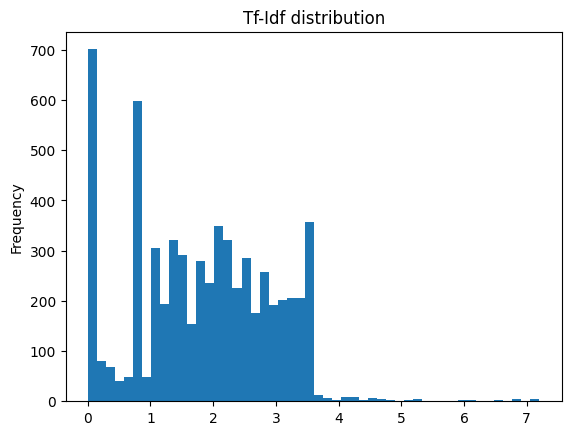

 44%|████████████████████████████████▉                                          | 1173/2675 [1:11:37<1:33:26,  3.73s/it]

In [ ]:
iteration = 1

# Define stopping criteria (either k is reached or min_sim is triggered)
K_target = 73

points = get_points(gdf, tessellation)
loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL').rename(columns={'TRIP_ID': 'freq'})
loc_frequencies['tf_idf'] = loc_frequencies.apply(lambda x: get_inverse_loc_frequency(x, loc_frequencies, points), axis=1)
Min_sim = loc_frequencies.tf_idf.quantile(0.75)**2
print(f"Min Sim threshold: {Min_sim}")

while True:
    print('\nNext Iteration: ', iteration)
    # Get new points gdf matched with tessellation that contains updated clustering column
    points = get_points(gdf, tessellation)
    
    # Compute location entropy for latest clustering (inverse normalized entropy)
#     points['location_entropy'] = points.tile_ID.progress_apply(lambda x: get_location_entropy(x, points))
#     points['location_entropy'] = points.location_entropy.apply(lambda x: 1 - (x - points.location_entropy.min())/(points.location_entropy.max() - points.location_entropy.min()))
#     points.location_entropy.plot.hist(bins=30, title="Inverse location_entropy distribution")
#     plt.show()
    
    # Update location frequencies and loc frequency-inverse cluster frequency
    loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL').rename(columns={'TRIP_ID': 'freq'})
    loc_frequencies['tf_idf'] = loc_frequencies.apply(lambda x: get_inverse_loc_frequency(x, loc_frequencies, points), axis=1)
    loc_frequencies.tf_idf.plot.hist(bins=50, title="Tf-Idf distribution")
    plt.show()
    
    # Recalculate similarities between latest clusters
    M = np.zeros((loc_frequencies.clustering_HL.nunique(), loc_frequencies.clustering_HL.nunique()))
    for i, cl_i in tqdm(enumerate(loc_frequencies.clustering_HL.unique()), total=loc_frequencies.clustering_HL.nunique()):
        for j, cl_j in enumerate(loc_frequencies.clustering_HL.unique()):
            if i == j:
                continue
            M[i, j] = get_location_similarity(cl_i, cl_j, loc_frequencies, points)
    np.fill_diagonal(M, 0)
    
    # Select n best links and assign new clustering IDs
    print('New links of clusters:')
    max_n =  get_max_n(M, 100)
    # Adjust scores based on overlapping trips in the two candidate clusters
    print(max_n)
    max_n = [(t[0] * 1/(find_nr_overlaps(loc_frequencies.clustering_HL.unique()[t[1]], loc_frequencies.clustering_HL.unique()[t[2]], gdf) + 1), t[1], t[2]) for t in max_n]
    print(max_n)
    
    # Take the best fitting clusters
    for i, tup in enumerate(sorted(max_n, reverse=True)[:100]):
        cl_1 = loc_frequencies.clustering_HL.unique()[tup[1]]
        cl_2 = loc_frequencies.clustering_HL.unique()[tup[2]]
        print(cl_1, cl_2)
        # Assign new clustering ids (merge clustering ids)
        gdf['clustering_HL'] = gdf.clustering_HL.apply(lambda x: cl_1 if x == cl_2 else x)
    
    # Evaluate result of iteration
    attack.evaluate(gdf.clustering_HL.tolist(), gdf)
    best_match_locsim = sorted(max_n, key=lambda x: x[0], reverse=True)[0][0]
    store_results_recursive_search(gdf.clustering_HL.tolist(), gdf, best_match_locsim)
    
    print('Iteration', iteration, 'done. ', gdf.clustering_HL.nunique(), 'clusters left.')
    
    # Check break conditions
    if gdf.clustering_HL.nunique() <= K_target:
        print("K clusters reached! Done!")
        save_clustering_result(gdf, data_name="geolife_private")
        break
    if sorted(max_n, reverse=True)[0][0] < Min_sim:
        print("No good matches to make left! Done!")
        save_clustering_result(gdf, data_name="geolife_private")
        break
                
    iteration += 1

In [ ]:
gdf.drop(['START_POINT', 'END_POINT'], axis=1).to_file("data/geolife/geolife_clustering_tfidf.geojson", driver="GeoJSON")